# Oxford-IIIT Pet Dataset Classification With EfficientDet

## Performance Comparison of Similar Models

<figure>
<img src="https://blog.roboflow.com/content/images/2020/06/yolov5-performance.png" style="width:700px">
</figure>

Check out the [EfficientDet Research Paper ](https://arxiv.org/pdf/1911.09070.pdf)  

## EfficientDet Structure
![image](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/efficientdet.png)

### Import Libraries

In [2]:
print("\n... PIP/APT INSTALLS AND DOWNLOADS/ZIP STARTING ...")
!pip install pandarallel
!pip install -q tensorflow_model_optimization
!pip install -q --upgrade tensorflow_datasets
print("... PIP/APT INSTALLS COMPLETE ...\n")


print("\n... IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")
# Machine Learning and Data Science Imports
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_datasets as tfds; print(f"\t\t– TENSORFLOW DATASETSVERSION: {tfds.__version__}");
import tensorflow_addons as tfa; print(f"\t\t– TENSORFLOW ADDONS VERSION: {tfa.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None; pd.set_option('max_columns', 100);
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");

# Other/Competition Related Imports
from pandarallel import pandarallel; pandarallel.initialize();

# Built In Imports
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from glob import glob
import warnings
import requests
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import scipy
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib import animation, rc; rc('animation', html='jshtml')
import matplotlib.patches as patches

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
import plotly
import PIL
import cv2
print("\n\n... IMPORTS COMPLETE ...\n")
    

print("\n... SEEDING FOR DETERMINISTIC BEHAVIOUR ...")
def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()
print("... SEEDING COMPLETE ...\n")

ROOT_DIR = "/kaggle"
INPUT_DIR = os.path.join(ROOT_DIR, "input")
LIB_DIR = os.path.join(INPUT_DIR, "automl-efficientdet-efficientnetv2")

print("\n... SETUP EFFICIENTDET REPO STARTING ...")
# To give access to automl files
sys.path.insert(0, os.path.join(LIB_DIR, "automl"))
sys.path.insert(0, os.path.join(LIB_DIR, "automl", "brain_automl"))
sys.path.insert(0, os.path.join(LIB_DIR, "automl", "brain_automl", "efficientdet"))
    
# EfficientNet Module Imports
import brain_automl
from brain_automl import efficientdet
from efficientdet.keras import efficientdet_keras
import hparams_config

print("... SETUP EFFICIENTDET REPO COMPLETE ...\n\n")


... PIP/APT INSTALLS AND DOWNLOADS/ZIP STARTING ...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cloud 0.1.13 requires tensorflow<3.0,>=1.15.0, which is not installed.
tensorflow-cloud 0.1.13 requires tensorflow-datasets<3.1.0, but you have tensorflow-datasets 4.4.0 which is incompatible.
... PIP/APT INSTALLS COMPLETE ...


... IMPORTS STARTING ...


	VERSION INFORMATION
		– TENSORFLOW VERSION: 2.4.1
		– TENSORFLOW DATASETSVERSION: 4.4.0
		– TENSORFLOW ADDONS VERSION: 0.12.1
		– NUMPY VERSION: 1.19.5
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
		– MATPLOTLIB VERSION: 3.4.2


... IMPORTS COMPLETE ...


... SEEDING FOR DETERMINISTIC BEHAVIOUR ...
... SEEDING COMPLETE ...


... SETUP EFFICIENTDET REPO STARTING ...
... SETUP EFFICIENTDET REPO COMPLETE ..

### Utility Functions

In [3]:
IMAGE_SIZE = (512,512)
SEG_SIZE = (128,128)

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


def load_image_train(datapoint):
    """Load images for training."""
    input_image = tf.image.resize(datapoint['image'], IMAGE_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], SEG_SIZE)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMAGE_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], SEG_SIZE)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

### Setup Paths to On-Disk Dataset And Plot Examples

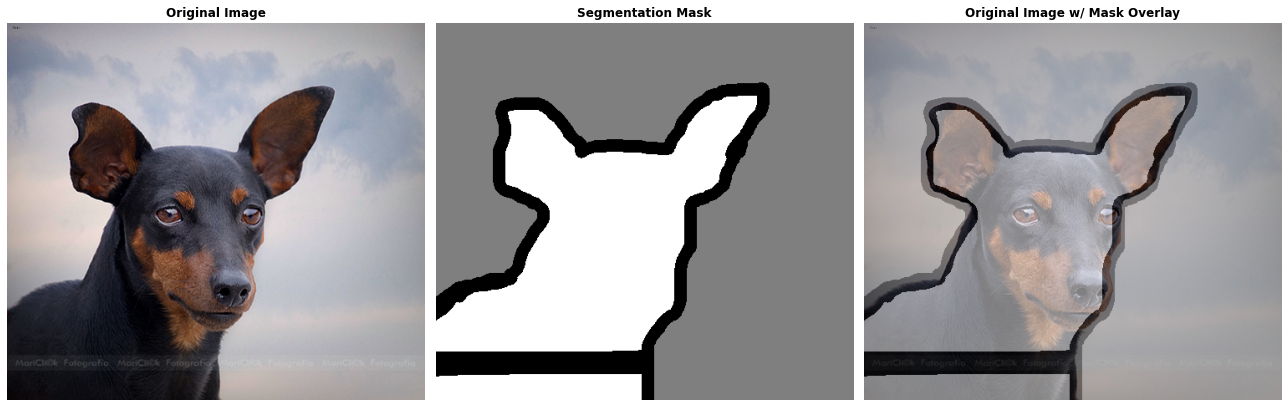

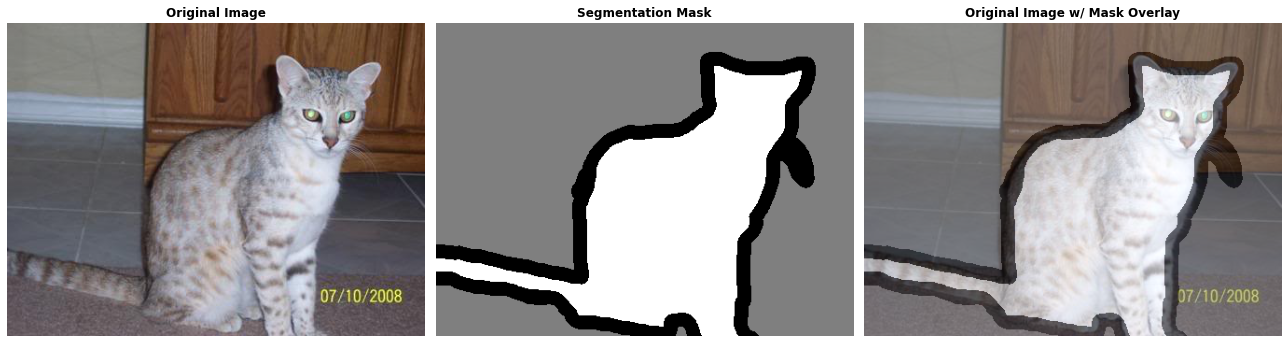

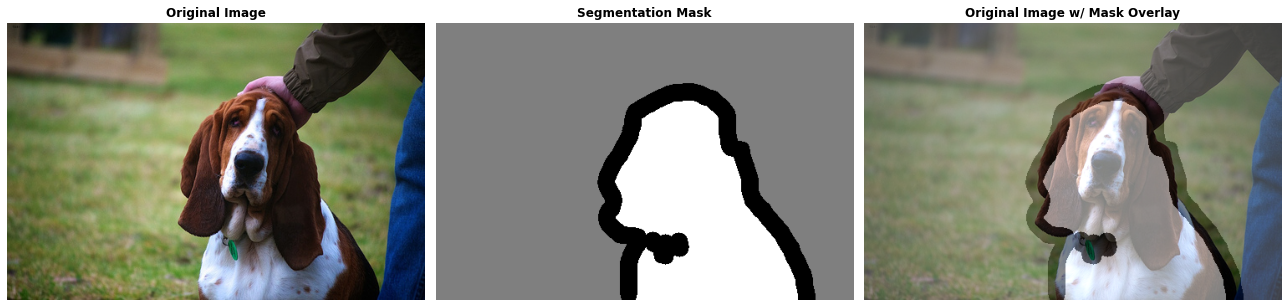

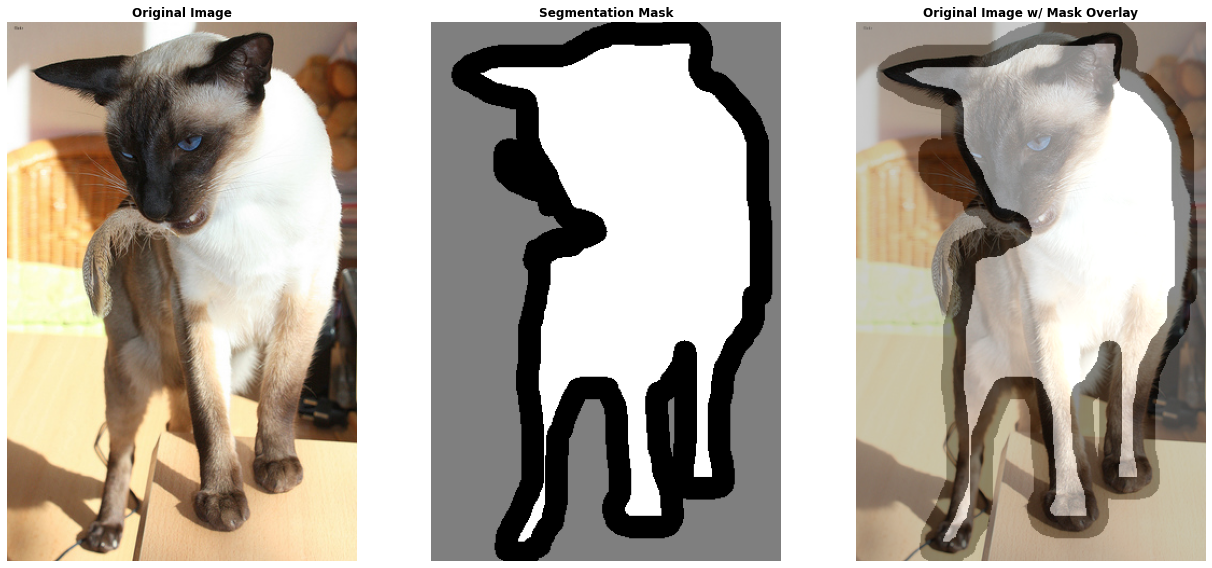

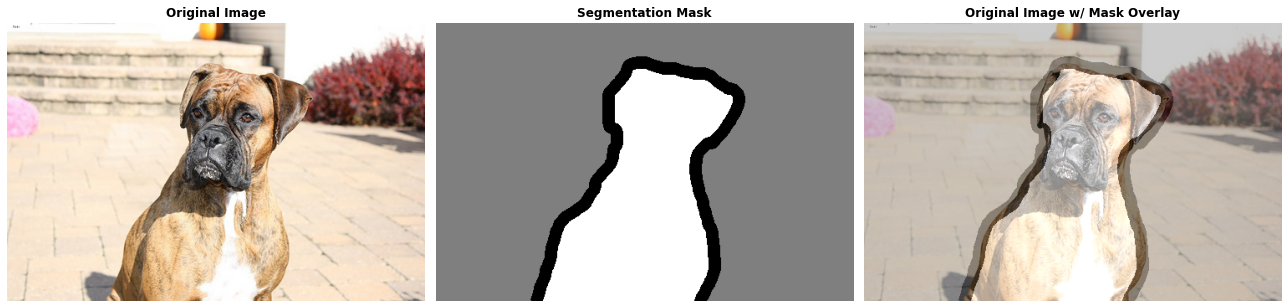

In [4]:
DS_DIR = os.path.join(INPUT_DIR, "the-oxfordiiit-pet-dataset")
IMAGE_DIR = os.path.join(DS_DIR, "images", "images")
LABEL_DIR = os.path.join(DS_DIR, "annotations", "annotations", "trimaps")

def plot_image_and_mask(name=None):
    """ TODO 
    
    Args:
        name (str, optional): Name of file to plot w/ mask.
            If no name is passed than the image will be picked randomly
     
    Returns:
        todo
        
    """
    if name is None:
        name=os.listdir(IMAGE_DIR)[int(random.random()*len(IMAGE_DIR))][:-4]
    
    ############################    
    # PLOTTING
    ############################
    plt.figure(figsize=(18,8))

    plt.subplot(1,3,1)
    original = np.asarray(Image.open(os.path.join(IMAGE_DIR, f'{name}.jpg')))/255
    plt.axis(False)
    plt.title("Original Image", fontweight="bold")
    plt.imshow(original)

    plt.subplot(1,3,2)
    mask = np.tile(np.expand_dims(np.asarray(Image.open(os.path.join(LABEL_DIR, f'{name}.png')))-1, axis=-1), 3)
    mask = 1-mask/np.max(mask)
    
    plt.axis(False)
    plt.title("Segmentation Mask", fontweight="bold")
    plt.imshow(mask)

    plt.subplot(1,3,3)
    combo = cv2.addWeighted(original,0.55,mask,0.5,0)
    plt.axis(False)
    plt.title("Original Image w/ Mask Overlay", fontweight="bold")
    plt.imshow(combo)

    plt.tight_layout()
    plt.show()
    ############################
    
plot_image_and_mask()
plot_image_and_mask()
plot_image_and_mask()
plot_image_and_mask()
plot_image_and_mask()

In [5]:
BATCH_SIZE = 8
tfds_ds, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

n_train = info.splits['train'].num_examples
n_train_steps_per_epoch = n_train//BATCH_SIZE
test_subsplits = 5
n_test_steps_per_epoch = info.splits['test'].num_examples // BATCH_SIZE // test_subsplits

train_ds = tfds_ds['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = tfds_ds['test'].map(load_image_test)

train_ds = train_ds.shuffle(BATCH_SIZE*10)\
                   .batch(BATCH_SIZE)\
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-train.tfrecord...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-test.tfrecord...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


### Setup EfficientDet

In [6]:
# Get the configuration parameters (for segmentation)
config = hparams_config.get_efficientdet_config('efficientdet-d0')
config.heads = ['segmentation']

# Make the d0-model
model = efficientdet_keras.EfficientDetNet(config=config)
model.build((1, 256, 256, 3))
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      multiple                  3634844   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  20800     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  179321    
_________________________________________________________________
segmentation_head (Segmentat multiple                  262531    
Total params: 4,097,496
Trainable params: 4,053,688
Non-trainable params: 43,808
_________________________________________________________________


In [87]:
 model.fit(
      train_ds,
      epochs=10,
      validation_data=test_ds,
      callbacks=[]
 )

460/460 [==============================] - 182s 394ms/step - loss: 0.2762 - accuracy: 0.8855 - val_loss: 0.3192 - val_accuracy: 0.8733


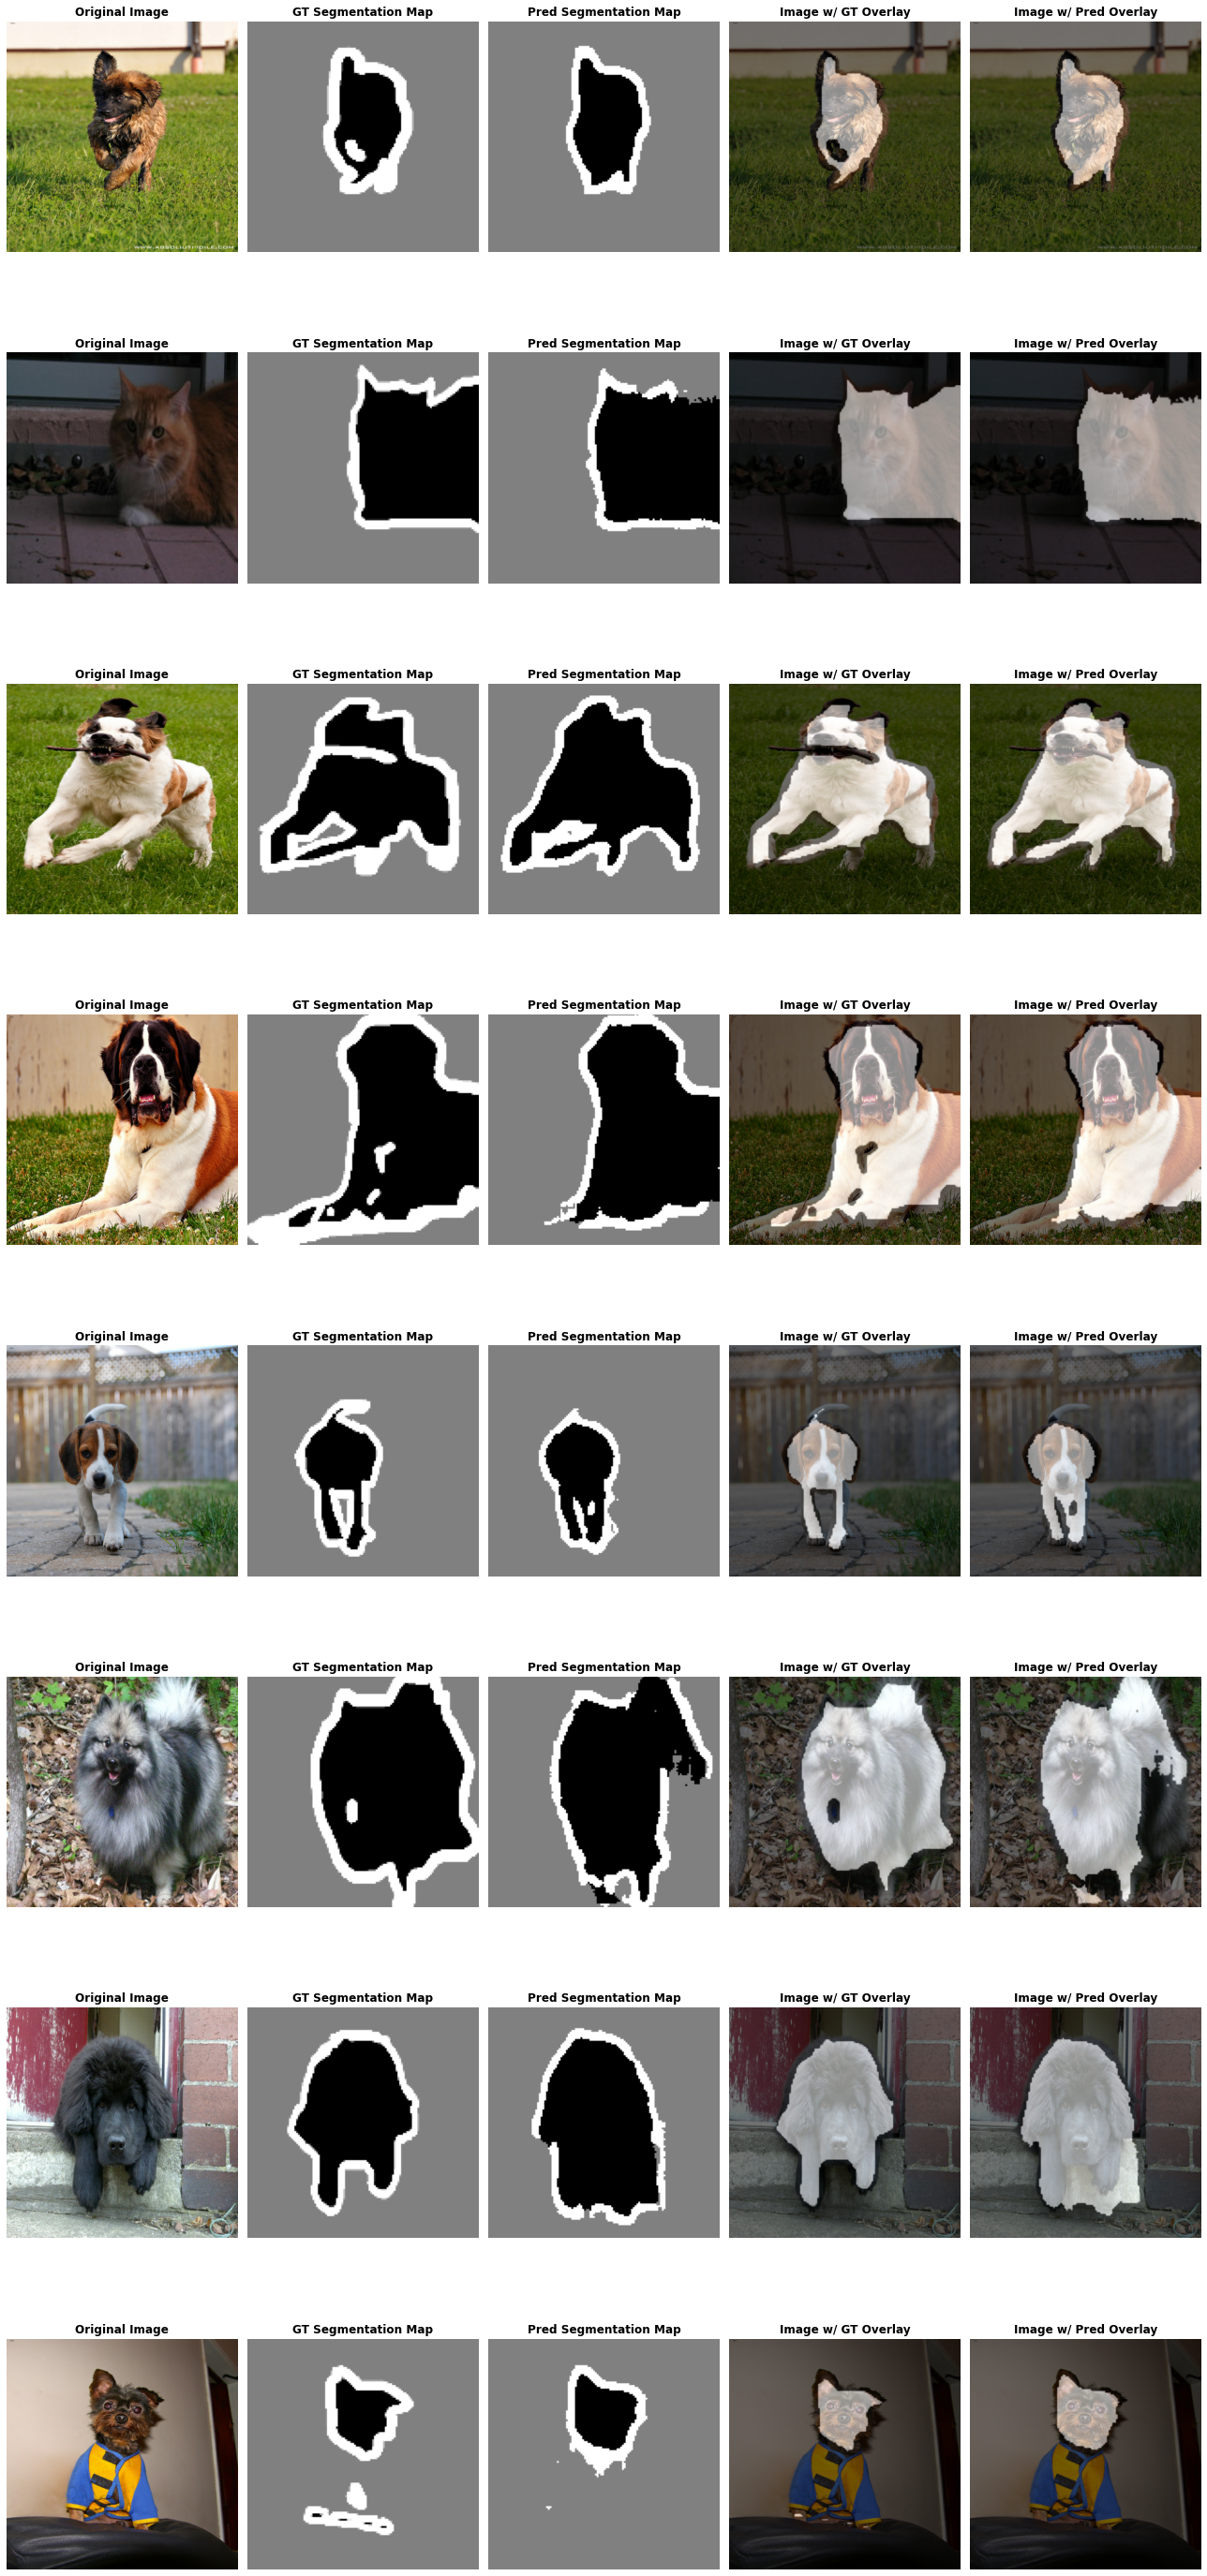

In [89]:
for img_batch, seg_batch in test_ds.take(1):
    pred_batch = create_mask(model.predict(img_batch))
    
plt.figure(figsize=(18,40))
for i, (img, seg, pred) in enumerate(zip(img_batch, seg_batch, pred_batch)):
    plt.subplot(BATCH_SIZE, 5, i*5+1)
    plt.imshow(img)
    plt.axis(False)
    plt.title("Original Image", fontweight="bold")
    
    plt.subplot(BATCH_SIZE, 5, i*5+2)
    plt.imshow(seg.numpy(), cmap="gray")
    plt.axis(False)
    plt.title("GT Segmentation Map", fontweight="bold")
    
    plt.subplot(BATCH_SIZE, 5, i*5+3)
    plt.imshow(pred, cmap="gray")
    plt.axis(False)
    plt.title("Pred Segmentation Map", fontweight="bold")
    
    plt.subplot(BATCH_SIZE, 5, i*5+4)
    plt.axis(False)
    plt.title("Image w/ GT Overlay", fontweight="bold")
    plt.imshow(img)
    plt.imshow(cv2.resize(1-np.tile(seg.numpy(), 3), IMAGE_SIZE), cmap="jet", alpha=0.55)
    
    plt.subplot(BATCH_SIZE, 5, i*5+5)
    plt.axis(False)
    plt.title("Image w/ Pred Overlay", fontweight="bold")
    plt.imshow(img)
    plt.imshow(cv2.resize(1-np.tile(pred.numpy().astype(np.float32), 3), IMAGE_SIZE), cmap="jet", alpha=0.55)
    
plt.tight_layout()
plt.show()

### Inference

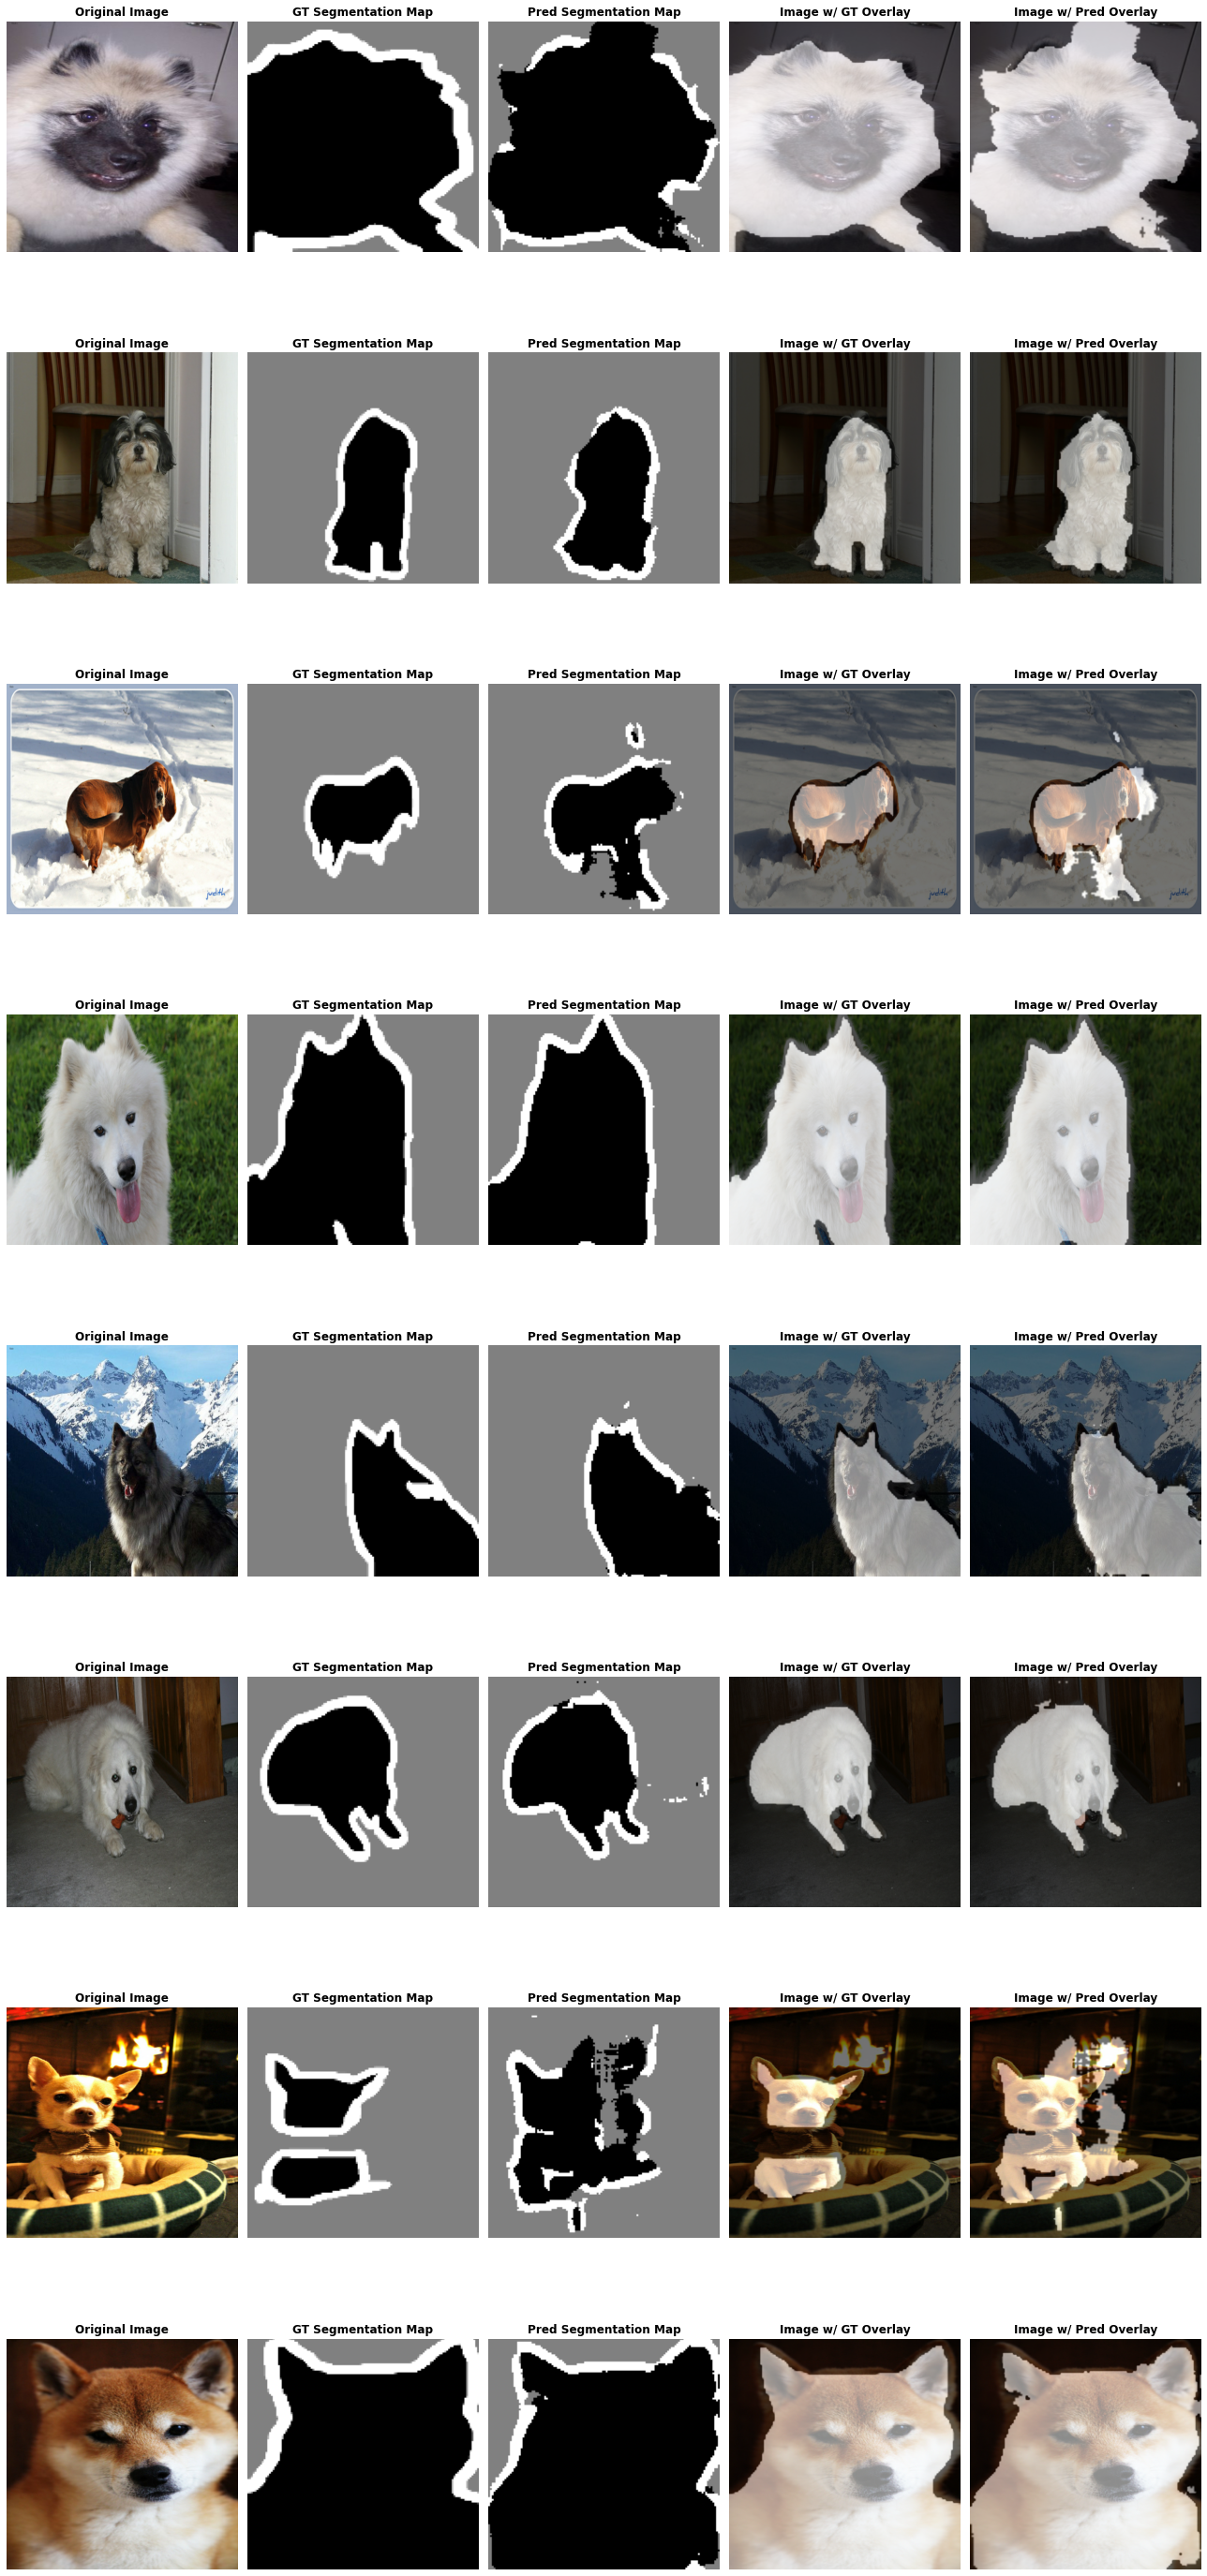

In [88]:
for img_batch, seg_batch in test_ds.skip(1).take(1):
    pred_batch = create_mask(model.predict(img_batch))
    
plt.figure(figsize=(18,40))
for i, (img, seg, pred) in enumerate(zip(img_batch, seg_batch, pred_batch)):
    plt.subplot(BATCH_SIZE, 5, i*5+1)
    plt.imshow(img)
    plt.axis(False)
    plt.title("Original Image", fontweight="bold")
    
    plt.subplot(BATCH_SIZE, 5, i*5+2)
    plt.imshow(seg.numpy(), cmap="gray")
    plt.axis(False)
    plt.title("GT Segmentation Map", fontweight="bold")
    
    plt.subplot(BATCH_SIZE, 5, i*5+3)
    plt.imshow(pred, cmap="gray")
    plt.axis(False)
    plt.title("Pred Segmentation Map", fontweight="bold")
    
    plt.subplot(BATCH_SIZE, 5, i*5+4)
    plt.axis(False)
    plt.title("Image w/ GT Overlay", fontweight="bold")
    plt.imshow(img)
    plt.imshow(cv2.resize(1-np.tile(seg.numpy(), 3), IMAGE_SIZE), cmap="jet", alpha=0.55)
    
    plt.subplot(BATCH_SIZE, 5, i*5+5)
    plt.axis(False)
    plt.title("Image w/ Pred Overlay", fontweight="bold")
    plt.imshow(img)
    plt.imshow(cv2.resize(1-np.tile(pred.numpy().astype(np.float32), 3), IMAGE_SIZE), cmap="jet", alpha=0.55)
    
plt.tight_layout()
plt.show()